In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from PIL import Image

import random
import time

try:
    from torchsummary import summary
except:
    !pip install torch_summary
    from torchsummary import summary
    
import os
import shutil
from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [3]:
!git clone https://github.com/Almotasembelah/Age_Gender_Race_Classification.git

Cloning into 'Age_Gender_Race_Classification'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 152 (delta 36), reused 141 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (152/152), 29.60 KiB | 3.70 MiB/s, done.
Resolving deltas: 100% (36/36), done.


In [4]:
import shutil

shutil.move('Age_Gender_Race_Classification/models', 'models')
shutil.move('Age_Gender_Race_Classification/utils', 'utils')
! rm -r Age_Gender_Race_Classification

In [5]:
# import importlib
# import models, utils
# importlib.reload(utils)
# importlib.reload(models)
from utils.manager import *
from models.models import *
from models.cnn_model import *
from utils.data import *

In [6]:
root = '/kaggle/input/fairface/FairFace/'
train_csv = root + 'train_labels.csv'
val_csv = root + 'val_labels.csv'
train_labels = pd.read_csv(train_csv)
val_labels = pd.read_csv(val_csv)

# Loading the Model


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
val_transform = transforms.Compose([ 
                                transforms.Resize(224),
                                transforms.ToTensor(),                            
                               ])

val_dataset = FairFaceDataset(val_labels, transform=val_transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, drop_last=True)

In [9]:
mlt_model = EfficientNetB0(1024, Task.AGE, freeze=False)
mlt_model.model.classifier.fc_age = nn.Sequential(
                                            nn.Linear(1280, 1024, bias=False),
                                            nn.BatchNorm1d(1024),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout1d(0.2),
                                            nn.Linear(1024, 512, bias=False),
                                            nn.BatchNorm1d(512),
                                            nn.ReLU(inplace=True),
                                            nn.Dropout1d(0.2),
                                            nn.Linear(512, 17)
                                            )
mlt_optimizer = optim.Adam(lr=0.001, params = mlt_model.parameters())
mlt_mm = ModelManagerV2(mlt_model, mlt_optimizer, [None, None, None])
mlt_mm.set_dataloaders(val_loader)
mlt_mm.set_tasks_names('Gen', 'Age', 'Race')

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 67.4MB/s]


In [10]:
mlt_mm.load_checkpoint('/kaggle/input/bestv1/pytorch/default/1/best (1)')

Forward pass took 933.70 ms
Class : Male with probability 99.99%
---------------
Class 1: 0-2 with probability 0.00%
Class 2: 3-9 with probability 0.04%
Class 3: 10-19 with probability 2.86%
Class 4: 20-29 with probability 32.06%
Class 5: 30-39 with probability 36.40%
Class 6: 40-49 with probability 23.55%
Class 7: 50-59 with probability 4.37%
Class 8: 60-69 with probability 0.71%
Class 9: more than 70 with probability 0.00%
----------------------
Class 1: White with probability 39.55%
Class 2: Latino_Hispanic with probability 31.96%
Class 3: Black with probability 4.40%
Class 4: East Asian with probability 0.31%
Class 5: Indian with probability 0.37%
Class 6: Southeast Asian with probability 0.71%
Class 7: Middle Eastern with probability 22.70%
Predictions:
gender:  Male age:  30-39 race:  White


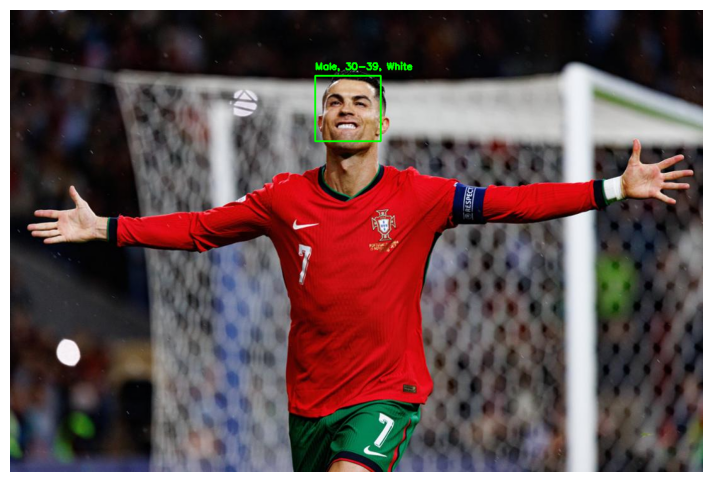

In [11]:
import cv2
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from io import BytesIO

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

mlt_model.to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

gender_labels = val_dataset.classes[0]
age_labels = val_dataset.classes[1]
race_labels = val_dataset.classes[2]

def classify_faces(image_url):
    # Read image from URL
    response = requests.get(image_url)
    img = np.array(Image.open(BytesIO(response.content)))

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

    results = []
    
    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]  # Extract face ROI
        face_pil = Image.fromarray(face)  # Convert to PIL image
        face_tensor = transform(face_pil).to(device)
        #print classes probabilities
        printNetResults(mlt_model, face_tensor, val_dataset.gender_classes, val_dataset.age_classes, val_dataset.race_classes)
        mlt_model.eval()
        # Forward pass through the model
        with torch.no_grad():
            preds = mlt_model(face_tensor.unsqueeze(0))
            gender_pred, age_pred, race_pred = preds[:, 0], preds[:, 1:10], preds[:, 10:]

        # Get predicted labels
        gender = gender_labels[torch.argmax(gender_pred).item()]
        age = age_labels[torch.argmax(age_pred).item()]
        race = race_labels[torch.argmax(race_pred).item()]

        results.append({"Gender": gender, "Age": age, "Race": race, "Coordinates": (x, y, w, h)})

        # Draw bounding box and labels
        label = f"{gender}, {age}, {race}"
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    return results

image_url = "https://www.fussball.news/assets/images/36/290/36290513-cristiano-ronaldo-seen-celebrating-after-scoring-goal-during-uefa-nations-league-game-between-national-teams-of-portugal-RdBG.jpg"
predictions = classify_faces(image_url)

Forward pass took 12.45 ms
Class : Male with probability 99.85%
---------------
Class 1: 0-2 with probability 0.00%
Class 2: 3-9 with probability 0.02%
Class 3: 10-19 with probability 0.37%
Class 4: 20-29 with probability 10.57%
Class 5: 30-39 with probability 44.71%
Class 6: 40-49 with probability 39.68%
Class 7: 50-59 with probability 4.62%
Class 8: 60-69 with probability 0.04%
Class 9: more than 70 with probability 0.00%
----------------------
Class 1: White with probability 96.53%
Class 2: Latino_Hispanic with probability 0.25%
Class 3: Black with probability 0.03%
Class 4: East Asian with probability 0.00%
Class 5: Indian with probability 0.02%
Class 6: Southeast Asian with probability 0.00%
Class 7: Middle Eastern with probability 3.16%
Predictions:
gender:  Male age:  30-39 race:  White


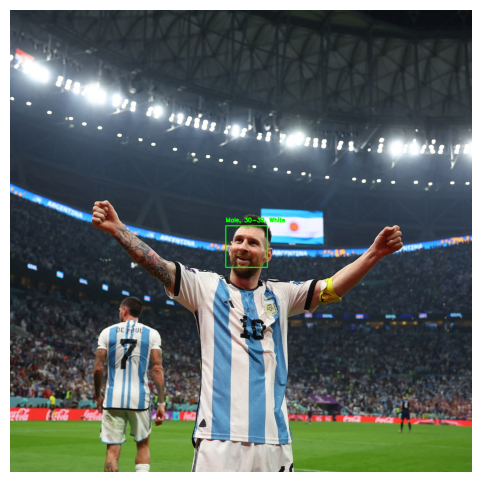

In [12]:
image_url = "https://www.reuters.com/resizer/v2/https%3A%2F%2Fcloudfront-us-east-2.images.arcpublishing.com%2Freuters%2FMSGDYKIKPZLRTHCV2U6X6IKUYA.jpg?auth=c7c0e8a1fa3206ee1e4a772fefc76a28ca9868a91bf3eb642750e6879d492dd2&height=1200&width=1200&quality=80&smart=true"
predictions = classify_faces(image_url)

Forward pass took 12.52 ms
Class : Male with probability 99.82%
---------------
Class 1: 0-2 with probability 0.00%
Class 2: 3-9 with probability 0.08%
Class 3: 10-19 with probability 3.02%
Class 4: 20-29 with probability 24.72%
Class 5: 30-39 with probability 42.89%
Class 6: 40-49 with probability 26.52%
Class 7: 50-59 with probability 2.64%
Class 8: 60-69 with probability 0.13%
Class 9: more than 70 with probability 0.00%
----------------------
Class 1: White with probability 13.77%
Class 2: Latino_Hispanic with probability 34.24%
Class 3: Black with probability 1.39%
Class 4: East Asian with probability 2.31%
Class 5: Indian with probability 0.51%
Class 6: Southeast Asian with probability 3.48%
Class 7: Middle Eastern with probability 44.31%
Predictions:
gender:  Male age:  30-39 race:  Middle Eastern
Forward pass took 11.61 ms
Class : Male with probability 98.44%
---------------
Class 1: 0-2 with probability 0.00%
Class 2: 3-9 with probability 0.14%
Class 3: 10-19 with probability 

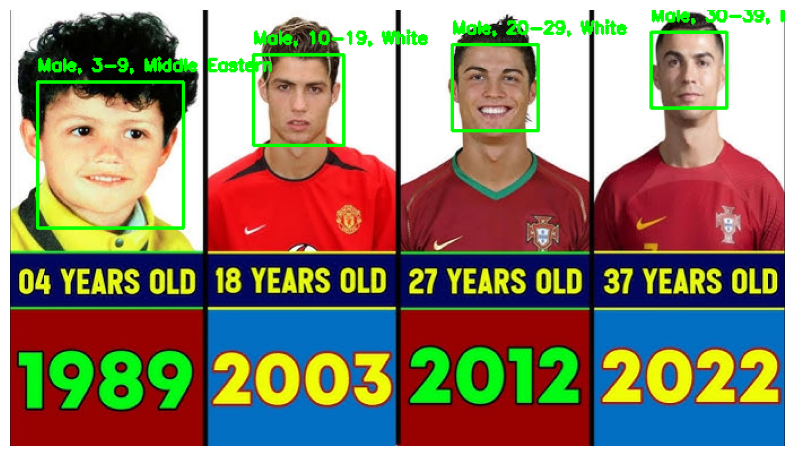

In [13]:
image_url = "https://i.ytimg.com/vi/BO7KVwrgeIk/hq720.jpg?sqp=-oaymwEhCK4FEIIDSFryq4qpAxMIARUAAAAAGAElAADIQj0AgKJD&rs=AOn4CLCqd_UHBFJWsOnIvT17g2uLb1JzHA"
predictions = classify_faces(image_url)